In [1]:
import numpy as np

from copy import copy

from pycbc.types import TimeSeries, load_frequencyseries
from pycbc.psd import interpolate

from scipy.signal import windows

import ldc.io.hdf5 as hdfio

from matplotlib import pyplot as plt
plt.style.use('../paper.mplstyle')

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
# This cell contains the information about inputs

input_data = '../datasets/LDC2_sangria_hm_training.h5'
output_format = '{channel}_sangria_hm_PSD.txt'
segment_duration = 1576800

In [3]:
# Load in the sangria dataset

tdi_ts, tdi_descr = hdfio.load_array(input_data, name="obs/tdi")
X = tdi_ts['X']
Y = tdi_ts['Y']
Z = tdi_ts['Z']

In [4]:
# Convert to AET timeseries
A = (Z - X)/np.sqrt(2)
E = (X - 2*Y + Z)/np.sqrt(6)
T = (X + Y + Z)/np.sqrt(3)

A_ts = TimeSeries(A, delta_t=5.)
E_ts = TimeSeries(E, delta_t=5.)
T_ts = TimeSeries(T, delta_t=5.)

In [5]:
# Calculate the PSDs

A_psd = A_ts.psd(segment_duration)
E_psd = E_ts.psd(segment_duration)
T_psd = T_ts.psd(segment_duration)

A_psd = interpolate(A_psd, A_ts.delta_f)
E_psd = interpolate(E_psd, E_ts.delta_f)
T_psd = interpolate(T_psd, T_ts.delta_f)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
# Save to files for use in later analysis

# A_psd.save(output_format.format(channel='A'))
# E_psd.save(output_format.format(channel='E'))
# T_psd.save(output_format.format(channel='T'))

In [7]:
# We also want to plot the models that we used in the premerger paper
ae_model = load_frequencyseries('model_AE_TDI1_optimistic.txt')
t_model = load_frequencyseries('model_T_TDI1_optimistic.txt')


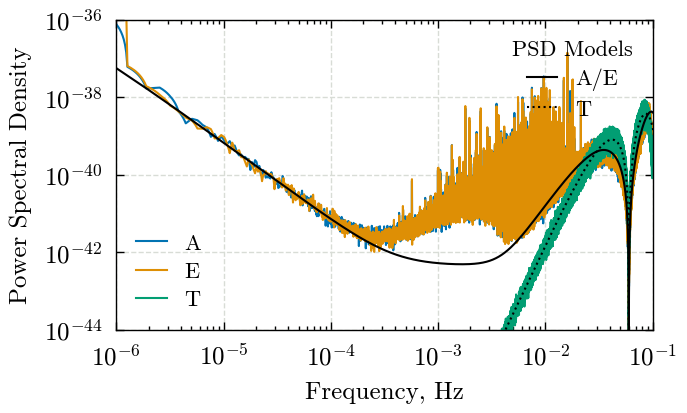

In [8]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(T_psd.sample_frequencies, T_psd, c=cycle[2], label='T')
ax.loglog(ae_model.sample_frequencies, ae_model, c='k')
ax.loglog(t_model.sample_frequencies, t_model, c='k', linestyle=':')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
leg1 = ax.legend(loc='lower left')
line2 = [
    ax.loglog([],[],c='k')[0],
    ax.loglog([],[],c='k', linestyle=':')[0]
]
labels2 = ['A/E', 'T']
ax.legend(line2, labels2, loc="upper right", title="PSD Models")
ax.add_artist(leg1)
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 1e-1])
ax.grid(zorder=-100)



Now lets remove the dip at 0.06 Hz, lets remove stuff between 0.03 and 0.09 Hz

In [9]:
def smooth_section(psd_freqseries, start_frequency, end_frequency):
    smoothed_section = np.logical_and(
        psd_freqseries.sample_frequencies >= start_frequency,
        psd_freqseries.sample_frequencies <= end_frequency
    )
    smoothed_freqs = psd_freqseries.sample_frequencies[smoothed_section]
    smoothed_y = psd_freqseries[smoothed_section]

    start_x = smoothed_freqs[0]
    start_y = smoothed_y[0]
    end_x = smoothed_freqs[-1]
    end_y = smoothed_y[-1]

    slope = (np.log(end_y) - np.log(start_y)) / (np.log(end_x) - np.log(start_x))
    intercept = np.log(start_y) - slope * np.log(start_x)

    line_out = np.exp(intercept) * (smoothed_freqs ** slope)

    # use a window function to multiply the line and the 
    N = smoothed_freqs.size
    window = windows.hann(N)
    windowed_line = line_out * window
    windowed_psd = smoothed_y * (1-window)
    fuzzy_line = windowed_line + windowed_psd
    psd_out = copy(psd_freqseries.data)
    psd_out[smoothed_section] = fuzzy_line

    return psd_out

In [10]:
smoothed_section = np.logical_and(A_psd.sample_frequencies >= 4e-2, A_psd.sample_frequencies <= 8e-2)

# We don't want to introduce a discontinuity here though!
# First, lets find the straight line (log-log space) which goes from the first removed datapoint to the last
smoothed_freqs = A_psd.sample_frequencies[smoothed_section]
smoothed_y_A = A_psd[smoothed_section]
smoothed_y_E = E_psd[smoothed_section]

start_x = smoothed_freqs[0]
start_y_A = smoothed_y_A[0]
start_y_E = smoothed_y_E[0]
end_x = smoothed_freqs[-1]
end_y_A = smoothed_y_A[-1]
end_y_E = smoothed_y_E[-1]

# y = mx + c, but in log space
slope_A = (np.log(end_y_A) - np.log(start_y_A)) / (np.log(end_x) - np.log(start_x))
intercept_A = np.log(start_y_A) - slope_A * np.log(start_x)

line_out_A = np.exp(intercept_A) * (smoothed_freqs ** slope_A)


slope_E = (np.log(end_y_E) - np.log(start_y_E)) / (np.log(end_x) - np.log(start_x))
intercept_E = np.log(start_y_E) - slope_A * np.log(start_x)

line_out_E = np.exp(intercept_E) * (smoothed_freqs ** slope_E)

# use a window function to multiply the line and the 
N = len(smoothed_freqs)
window = windows.hann(N)
windowed_line_A = line_out_A * window
windowed_psd_A = smoothed_y_A * (1-window)
fuzzy_line_A = windowed_line_A + windowed_psd_A
windowed_line_E = line_out_E * window
windowed_psd_E = smoothed_y_E * (1-window)
fuzzy_line_E = windowed_line_E + windowed_psd_E

A_psd_smoothed = smooth_section(A_psd, 4e-2, 8e-2)
E_psd_smoothed = smooth_section(E_psd, 4e-2, 8e-2)

In [11]:
np.savetxt(
    'A_sangria_hm_SMOOTHED_PSD.txt',
    np.array([
        A_psd.sample_frequencies,
        A_psd_smoothed
    ]).T,
)

np.savetxt(
    'E_sangria_hm_SMOOTHED_PSD.txt',
    np.array([
        E_psd.sample_frequencies,
        E_psd_smoothed
    ]).T,
)

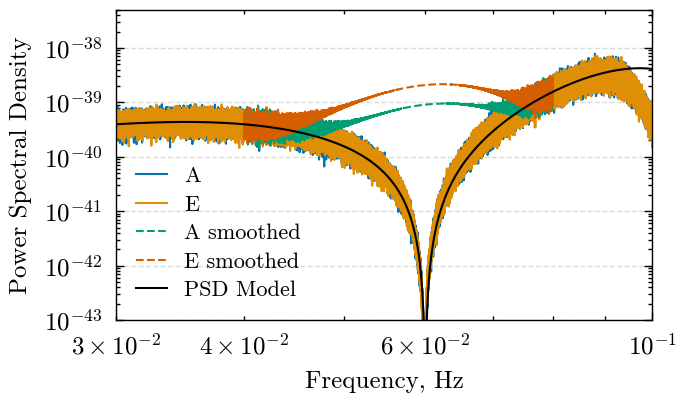

In [12]:
fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(smoothed_freqs, fuzzy_line_A, label='A smoothed', linestyle='--', c=cycle[2])
ax.loglog(smoothed_freqs, fuzzy_line_E, label='E smoothed', linestyle='--', c=cycle[3])

ax.loglog(ae_model.sample_frequencies, ae_model, c='k', label='PSD Model')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
ax.legend(loc='lower left')
ax.set_ylim([1e-43, 5e-38])
ax.set_xlim([3e-2, 1e-1])
ax.grid(zorder=-100)
